https://github.com/Azure/DeepLearningForTimeSeriesForecasting/blob/master/1_CNN_dilated.ipynb

In [42]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from glob import glob
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [43]:
data_dir = '/Users/dmalea/Git-Project-V2/energy_client'
energy = load_data(data_dir)[['load']]
energy.head()

,load
2023-05-15 00:15:00,0.13
2023-05-15 00:30:00,0.13
2023-05-15 00:45:00,0.13
2023-05-15 01:00:00,0.11
2023-05-15 01:15:00,0.10


In [44]:
valid_start_dt = '2023-05-19 05:00:00'
test_start_dt = '2023-05-20 14:30:00'

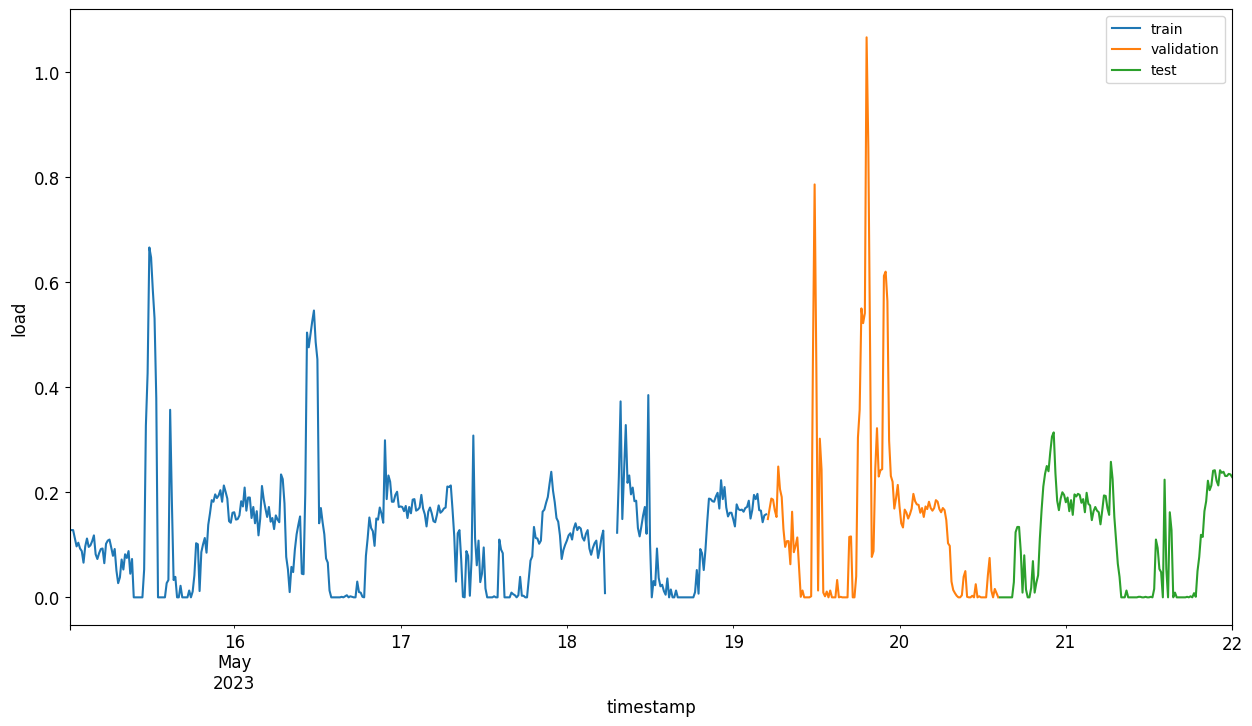

In [45]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'train'}) \
    .join(energy[(energy.index >=valid_start_dt) & (energy.index < test_start_dt)][['load']] \
          .rename(columns={'load':'validation'}), how='outer') \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [46]:
T = 10
HORIZON = 1

In [47]:
train = energy.copy()[energy.index < valid_start_dt][['load']]

In [48]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

,load
2023-05-15 00:15:00,0.19
2023-05-15 00:30:00,0.19
2023-05-15 00:45:00,0.19
2023-05-15 01:00:00,0.17
2023-05-15 01:15:00,0.15
2023-05-15 01:30:00,0.16
2023-05-15 01:45:00,0.14
2023-05-15 02:00:00,0.13
2023-05-15 02:15:00,0.10
2023-05-15 02:30:00,0.15


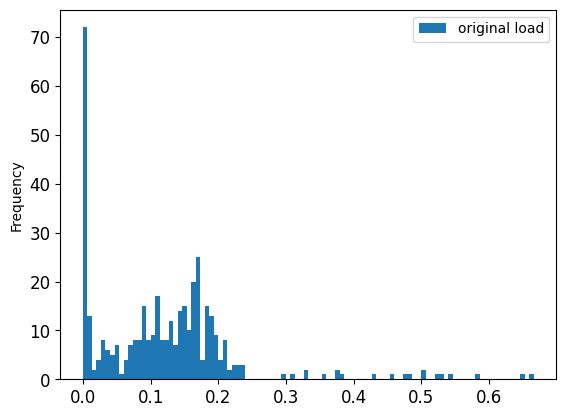

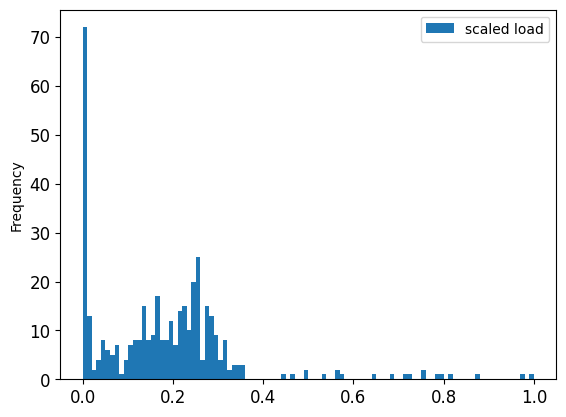

In [49]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [50]:
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['load'].shift(-1, freq='H')
train_shifted.head(10)

,load,y_t+1
2023-05-15 00:15:00,0.19,0.15
2023-05-15 00:30:00,0.19,0.16
2023-05-15 00:45:00,0.19,0.14
2023-05-15 01:00:00,0.17,0.13
2023-05-15 01:15:00,0.15,0.10
2023-05-15 01:30:00,0.16,0.15
2023-05-15 01:45:00,0.14,0.17
2023-05-15 02:00:00,0.13,0.14
2023-05-15 02:15:00,0.10,0.15
2023-05-15 02:30:00,0.15,0.16


In [51]:
for t in range(1, T+1):
    train_shifted['load_t-'+str(T-t)] = train_shifted['load'].shift(T-t, freq='H')
train_shifted = train_shifted.rename(columns={'load':'load_original'})
train_shifted.head(10)

,load_original,y_t+1,load_t-9,load_t-8,load_t-7,load_t-6,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
2023-05-15 00:15:00,0.19,0.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19
2023-05-15 00:30:00,0.19,0.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19
2023-05-15 00:45:00,0.19,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19
2023-05-15 01:00:00,0.17,0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.17
2023-05-15 01:15:00,0.15,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19,0.15
2023-05-15 01:30:00,0.16,0.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19,0.16
2023-05-15 01:45:00,0.14,0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19,0.14
2023-05-15 02:00:00,0.13,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.17,0.13
2023-05-15 02:15:00,0.10,0.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19,0.15,0.10
2023-05-15 02:30:00,0.15,0.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19,0.16,0.15


In [52]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,load_original,y_t+1,load_t-9,load_t-8,load_t-7,load_t-6,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
2023-05-15 09:15:00,0.11,0.00,0.19,0.15,0.10,0.15,0.11,0.10,0.14,0.04,0.12,0.11
2023-05-15 09:30:00,0.00,0.00,0.19,0.16,0.15,0.16,0.13,0.15,0.12,0.06,0.11,0.00
2023-05-15 09:45:00,0.00,0.00,0.19,0.14,0.17,0.18,0.14,0.16,0.14,0.11,0.13,0.00
2023-05-15 10:00:00,0.00,0.08,0.17,0.13,0.14,0.12,0.14,0.17,0.08,0.08,0.07,0.00
2023-05-15 10:15:00,0.00,0.49,0.15,0.10,0.15,0.11,0.10,0.14,0.04,0.12,0.11,0.00


In [53]:
y_train = train_shifted[['y_t+1']].to_numpy()

In [54]:
y_train.shape

(317, 1)

In [55]:
y_train[:3]

array([[0.],
       [0.],
       [0.]])

In [56]:
X_train = train_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_train = X_train[... , np.newaxis]

In [57]:
X_train.shape

(317, 10, 1)

In [58]:
X_train[:3]

array([[[0.19],
        [0.15],
        [0.1 ],
        [0.15],
        [0.11],
        [0.1 ],
        [0.14],
        [0.04],
        [0.12],
        [0.11]],

       [[0.19],
        [0.16],
        [0.15],
        [0.16],
        [0.13],
        [0.15],
        [0.12],
        [0.06],
        [0.11],
        [0.  ]],

       [[0.19],
        [0.14],
        [0.17],
        [0.18],
        [0.14],
        [0.16],
        [0.14],
        [0.11],
        [0.13],
        [0.  ]]])

In [59]:
train_shifted.head(3)

,load_original,y_t+1,load_t-9,load_t-8,load_t-7,load_t-6,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
2023-05-15 09:15:00,0.11,0.00,0.19,0.15,0.10,0.15,0.11,0.10,0.14,0.04,0.12,0.11
2023-05-15 09:30:00,0.00,0.00,0.19,0.16,0.15,0.16,0.13,0.15,0.12,0.06,0.11,0.00
2023-05-15 09:45:00,0.00,0.00,0.19,0.14,0.17,0.18,0.14,0.16,0.14,0.11,0.13,0.00


In [60]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load']]
valid.head()

,load
2023-05-18 20:00:00,0.09
2023-05-18 20:15:00,0.14
2023-05-18 20:30:00,0.19
2023-05-18 20:45:00,0.19
2023-05-18 21:00:00,0.18


In [61]:
valid['load'] = scaler.transform(valid)
valid.head()

,load
2023-05-18 20:00:00,0.14
2023-05-18 20:15:00,0.21
2023-05-18 20:30:00,0.28
2023-05-18 20:45:00,0.28
2023-05-18 21:00:00,0.27


In [62]:
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    valid_shifted['load_t-'+str(T-t)] = valid_shifted['load'].shift(T-t, freq='H')
valid_shifted = valid_shifted.dropna(how='any')
y_valid = valid_shifted['y+1'].to_numpy()
X_valid = valid_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_valid = X_valid[..., np.newaxis]

In [63]:
y_valid.shape

(130,)

In [64]:
X_valid.shape

(130, 10, 1)

In [65]:
from keras.models import Model, Sequential
from keras.layers import Conv1D, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [66]:
LATENT_DIM = 5
KERNEL_SIZE = 2
BATCH_SIZE = 32
EPOCHS = 10

In [67]:
model = Sequential()
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(T, 1)))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model.add(Flatten())
model.add(Dense(HORIZON, activation='linear'))

In [68]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 10, 5)          │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 10, 5)          │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 10, 5)          │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176 (704.00 B)

 Trainable params: 176 (704.00 B)

 Non-trainable params: 0 (0.00 B)

In [69]:
model.compile(optimizer='Adam', loss='mse')

In [70]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [71]:
best_val = ModelCheckpoint('model_{epoch:02d}.keras', save_best_only=True, mode='min')


In [72]:
history = model.fit(X_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Epoch 1/10


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0711 - val_loss: 0.1268
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0548 - val_loss: 0.1100
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0444 - val_loss: 0.0985
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0384 - val_loss: 0.0891
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0327 - val_loss: 0.0829
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0282 - val_loss: 0.0798
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0311 - val_loss: 0.0787
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0292 - val_loss: 0.0785
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0244 - val_loss: 0.0786
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0235 - val_loss: 0.0787


In [73]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("model_{:02d}.keras".format(best_epoch))

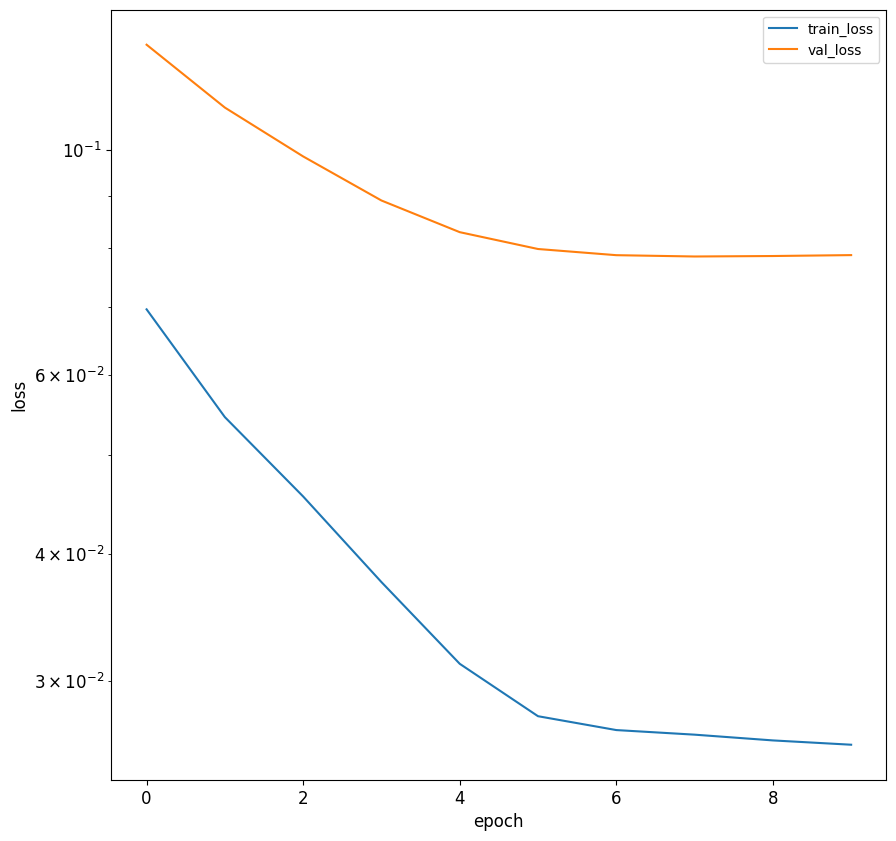

In [74]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [75]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load']]
test.head()

,load
2023-05-20 14:30:00,0.00
2023-05-20 14:45:00,0.00
2023-05-20 15:00:00,0.00
2023-05-20 15:15:00,0.00
2023-05-20 15:30:00,0.00


In [76]:
test['load'] = scaler.transform(test)
test.head()

,load
2023-05-20 14:30:00,0.00
2023-05-20 14:45:00,0.00
2023-05-20 15:00:00,0.00
2023-05-20 15:15:00,0.00
2023-05-20 15:30:00,0.00


In [77]:
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    test_shifted['load_t-'+str(T-t)] = test_shifted['load'].shift(T-t, freq='H')
test_shifted = test_shifted.dropna(how='any')
y_test = test_shifted['y_t+1'].to_numpy()
X_test = test_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_test = X_test[... , np.newaxis]

In [78]:
predictions = model.predict(X_test)
predictions

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


array([[0.2 ],
       [0.19],
       [0.19],
       [0.19],
       [0.19],
       [0.19],
       [0.19],
       [0.19],
       [0.18],
       [0.17],
       [0.18],
       [0.17],
       [0.18],
       [0.19],
       [0.19],
       [0.19],
       [0.19],
       [0.2 ],
       [0.2 ],
       [0.2 ],
       [0.21],
       [0.2 ],
       [0.2 ],
       [0.2 ],
       [0.21],
       [0.21],
       [0.22],
       [0.22],
       [0.22],
       [0.21],
       [0.2 ],
       [0.21],
       [0.21],
       [0.2 ],
       [0.2 ],
       [0.2 ],
       [0.21],
       [0.21],
       [0.21],
       [0.21],
       [0.2 ],
       [0.2 ],
       [0.2 ],
       [0.2 ],
       [0.19],
       [0.19],
       [0.2 ],
       [0.2 ],
       [0.2 ],
       [0.2 ],
       [0.2 ],
       [0.2 ],
       [0.2 ],
       [0.2 ],
       [0.2 ],
       [0.21],
       [0.19],
       [0.2 ],
       [0.2 ],
       [0.22],
       [0.23],
       [0.23],
       [0.23],
       [0.21],
       [0.21],
       [0.2 ],
       [0.

In [79]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2023-05-20 23:30:00,t+1,0.13,0.16
1,2023-05-20 23:45:00,t+1,0.13,0.18
2,2023-05-21 00:00:00,t+1,0.13,0.16
3,2023-05-21 00:15:00,t+1,0.13,0.20
4,2023-05-21 00:30:00,t+1,0.12,0.19


In [80]:
mape(eval_df['prediction'], eval_df['actual'])

inf

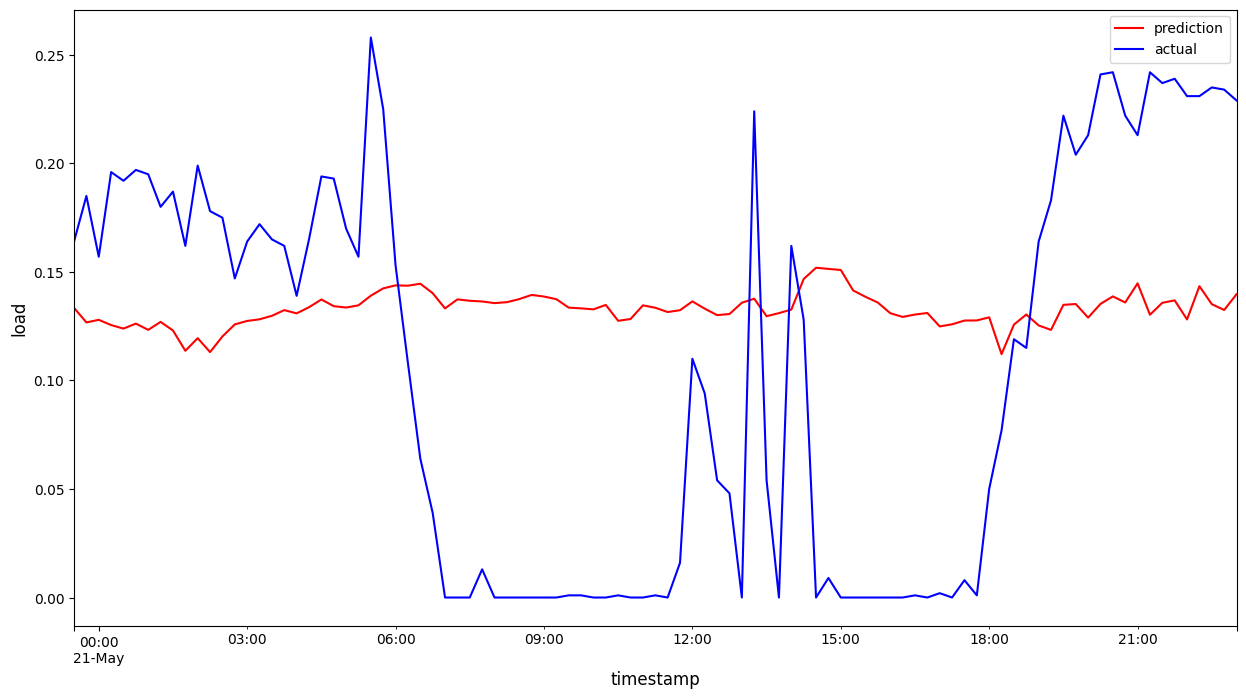

In [81]:
eval_df[eval_df.timestamp<'2023-05-23'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [82]:
for m in glob('model_*.keras'):
    os.remove(m)